## Download GWTC-1 data

In [1]:
!wget https://dcc.ligo.org/public/0157/P1800370/002/GWTC-1_sample_release.tar.gz

--2020-08-12 22:14:47--  https://dcc.ligo.org/public/0157/P1800370/002/GWTC-1_sample_release.tar.gz
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89895447 (86M) [application/x-gzip]
Saving to: ‘GWTC-1_sample_release.tar.gz’

GWTC-1_sample_relea 100%[===================>]  85.73M   109KB/s    in 15m 21s 

2020-08-12 22:30:11 (95.3 KB/s) - ‘GWTC-1_sample_release.tar.gz’ saved [89895447/89895447]



In [2]:
!tar -xvzf GWTC-1_sample_release.tar.gz

./GWTC-1_sample_release/
./GWTC-1_sample_release/GW170729_GWTC-1.hdf5
./GWTC-1_sample_release/GW151226_GWTC-1.hdf5
./GWTC-1_sample_release/GW170809_GWTC-1.hdf5
./GWTC-1_sample_release/GW170104_GWTC-1.hdf5
./GWTC-1_sample_release/GW170817_GWTC-1.hdf5
./GWTC-1_sample_release/GW170608_GWTC-1.hdf5
./GWTC-1_sample_release/GW170814_GWTC-1.hdf5
./GWTC-1_sample_release/GW151012_GWTC-1.hdf5
./GWTC-1_sample_release/GW170809_priorChoices_GWTC-1.hdf5
./GWTC-1_sample_release/GW170818_GWTC-1.hdf5
./GWTC-1_sample_release/GW150914_GWTC-1.hdf5
./GWTC-1_sample_release/GW170823_GWTC-1.hdf5


## Imports

In [51]:
import bilby
import gwpopulation as gwpop
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import corner

from astropy import cosmology, units
from scipy.interpolate import interp1d

from bilby.core.prior import Uniform, LogUniform, PriorDict, Constraint
from gwpopulation.models import mass, spin

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Viewing the contents of the files

- The Default model uses this waveform: `IMRPhenomPv2` - Inspiral-Merger-Ringdown Phenomena v2 
- `SEOBNRv3` - Spin-Aligned Effective One Body Numerical Relativity
- The Gaussian model uses this waveform: `Overall` which combines the above two models

In [4]:
f = h5py.File('GWTC-1_sample_release/GW150914_GWTC-1.hdf5', 'r')
f.keys()

<KeysViewHDF5 ['IMRPhenomPv2_posterior', 'Overall_posterior', 'SEOBNRv3_posterior', 'prior']>

In [5]:
df1 = pd.DataFrame(np.array(f['IMRPhenomPv2_posterior']))
df1.keys()

Index(['costheta_jn', 'luminosity_distance_Mpc', 'right_ascension',
       'declination', 'm1_detector_frame_Msun', 'm2_detector_frame_Msun',
       'spin1', 'spin2', 'costilt1', 'costilt2'],
      dtype='object')

### Changing the names of some of the parameters to make them work with gwpopulation

We do this for `IMRPhenomPv2_posterior` first.

In [52]:
parameter_translator = dict(
    mass_1_det = 'm1_detector_frame_Msun',
    mass_2_det = 'm2_detector_frame_Msun',
    luminosity_distance = 'luminosity_distance_Mpc',
    a_1 = 'spin1',
    a_2 = 'spin2',
    cos_tilt_1 = 'costilt1',
    cos_tilt_2 = 'costilt2')

In [53]:
posteriors = list()
priors = list()

file = 'GWTC-1_sample_release/GW{}_GWTC-1.hdf5'

events = ['150914', '151012', '151226', '170104', '170608', '170729', '170809', '170814', 
          '170818', '170823']

for event in events:
    _posterior = pd.DataFrame()
    _prior = pd.DataFrame()
    with h5py.File(file.format(event), 'r') as ff:
        for my_key, gwtc_key in parameter_translator.items():
            _posterior[my_key] = ff['IMRPhenomPv2_posterior'][gwtc_key]
            _prior[my_key] = ff['prior'][gwtc_key]
    posteriors.append(_posterior)
    priors.append(_prior)

In [55]:
priors[0]

,mass_1_det,mass_2_det,luminosity_distance,a_1,a_2,cos_tilt_1,cos_tilt_2
0,69.441911,45.307698,1587.709660,0.710862,0.329071,-0.729440,0.648406
1,69.719526,45.297547,1361.813595,0.826819,0.786825,0.463214,0.416947
2,48.511864,39.084524,1786.684917,0.533594,0.114619,-0.841181,-0.534239
3,21.601124,10.014871,1630.223664,0.033215,0.846267,-0.961511,0.174599
4,77.740300,42.433984,1157.158151,0.473868,0.056880,0.037607,0.953797
...,...,...,...,...,...,...,...
34388,69.609696,29.467936,1526.467081,0.124020,0.694278,-0.562501,0.626963
34389,34.375390,13.076269,1199.753762,0.028998,0.401757,-0.164754,-0.312023
34390,57.574401,35.328709,1574.084034,0.213279,0.160484,0.103354,-0.006787
34391,51.772700,24.741988,1185.847593,0.240349,0.015032,-0.581687,0.952311


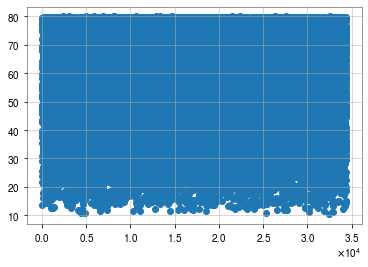

In [59]:
plt.plot(priors[0]['mass_1_det'], 'o')

In [4]:
posteriors[0]

,mass_1_det,mass_2_det,luminosity_distance,a_1,a_2,cos_tilt_1,cos_tilt_2
0,43.561878,30.006974,360.963036,0.481479,0.551643,0.012162,0.137818
1,37.006684,35.723611,538.067256,0.323226,0.225597,0.454174,-0.482123
2,35.747480,34.267309,378.730720,0.490409,0.229346,-0.069300,-0.493216
3,45.168491,26.692544,446.937909,0.907815,0.128135,-0.127557,-0.694896
4,36.308165,35.889917,496.628291,0.144858,0.437158,0.487946,-0.237507
...,...,...,...,...,...,...,...
40831,38.577778,31.417375,503.472940,0.268453,0.194847,0.039890,-0.925528
40832,37.253314,33.156328,478.421089,0.805262,0.823590,0.655502,-0.985068
40833,40.528821,30.134671,516.916074,0.437801,0.408049,-0.277677,-0.280263
40834,35.683458,34.021918,464.564783,0.214438,0.819591,-0.557688,-0.119711


### Some Important Definitions

- Individual masses = mi; Individual spins = Si
- Total Mass = m1 + m2
- Mass ratio (q) = m2/m1, where m1 ≥ m2.
- Effective spin which is a combination of the spin components along the orbital angular momentum direction Lˆ, χeff = (S1/m1 + S2/m2)* Lˆ/M
- We will also characterize BH spins using the dimensionless spin variables χi = Si/m2i

Due to the expansion of spacetime as the gravitational wave is propagating, the frequencies measured by the instrument are redshifted relative to those emitted at the source (Thorne 1983). We capture these effects by distinguishing between masses as they would be measured in the source frame, denoted as above, and the redshifted masses, (1+z)mi, which are measured in the detector frame. 

- Hence m(source) = mass_det / (1+z)

Meanwhile, the amplitude of the wave scales inversely with the luminosity distance (Misner et al. 1973). We use the GW measurement of the luminosity distance to obtain the cosmological redshift and therefore convert between detector-frame and source-frame masses. We assume a fixed Planck 2015 (Planck Collaboration et al. 2016) cosmology throughout to con- vert between a source’s luminosity distance and its redshift (Hogg 1999).

To do this, first create a function that takes in luminosity distance and gives back redshift. Here that function is `dl_to_z`.

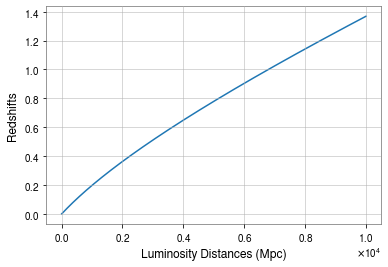

In [10]:
luminosity_distances = np.linspace(1, 10000, 1000)
redshifts = np.array([cosmology.z_at_value(cosmology.Planck15.luminosity_distance, 
                                                   dl * units.Mpc) for dl in luminosity_distances])
dl_to_z = interp1d(luminosity_distances, redshifts)

plt.plot(luminosity_distances, redshifts)
plt.xlabel('Luminosity Distances (Mpc)')
plt.ylabel('Redshifts')
plt.show()

In [19]:
def chi_eff(a1, a2, m1, m2, cost1, cost2):
    chieff = (a1*m1*cost1 + a2*m2*cost2)/(m1+m2)
    return chieff

In [20]:
for posterior in posteriors:
    posterior['redshift'] = dl_to_z(posterior['luminosity_distance'])
    posterior['mass_1'] = posterior['mass_1_det'] / (1 + posterior['redshift'])
    posterior['mass_2'] = posterior['mass_2_det'] / (1 + posterior['redshift'])
    posterior['mass_ratio'] = posterior['mass_2'] / posterior['mass_1']
    posterior['chi_eff'] = chi_eff(posterior['a_1'], posterior['a_2'], 
                                posterior['mass_1'], posterior['mass_2'], 
                                posterior['cos_tilt_1'], posterior['cos_tilt_2'])

In [21]:
posteriors[0]

,mass_1_det,mass_2_det,luminosity_distance,a_1,a_2,cos_tilt_1,cos_tilt_2,redshift,mass_1,mass_2,mass_ratio,chi_eff
0,43.561878,30.006974,360.963036,0.481479,0.551643,0.012162,0.137818,0.077120,40.442921,27.858525,0.688836,0.034477
1,37.006684,35.723611,538.067256,0.323226,0.225597,0.454174,-0.482123,0.112285,33.270867,32.117319,0.965329,0.021272
2,35.747480,34.267309,378.730720,0.490409,0.229346,-0.069300,-0.493216,0.080717,33.077567,31.707947,0.958594,-0.072715
3,45.168491,26.692544,446.937909,0.907815,0.128135,-0.127557,-0.694896,0.094378,41.273212,24.390609,0.590955,-0.105859
4,36.308165,35.889917,496.628291,0.144858,0.437158,0.487946,-0.237507,0.104189,32.882193,32.503410,0.988481,-0.016067
...,...,...,...,...,...,...,...,...,...,...,...,...
40831,38.577778,31.417375,503.472940,0.268453,0.194847,0.039890,-0.925528,0.105532,34.895216,28.418332,0.814390,-0.075042
40832,37.253314,33.156328,478.421089,0.805262,0.823590,0.655502,-0.985068,0.100608,33.847949,30.125472,0.890024,-0.102760
40833,40.528821,30.134671,516.916074,0.437801,0.408049,-0.277677,-0.280263,0.108162,36.572999,27.193371,0.743537,-0.118494
40834,35.683458,34.021918,464.564783,0.214438,0.819591,-0.557688,-0.119711,0.097872,32.502395,30.988976,0.953437,-0.109108


## Specify the Model

#### Model A - Default (Model C as shown in the table below) 

Model for mass distribution: Talbot and Thrane 2018

- gwpop.models.mass.SinglePeakSmoothedMassDistribution()

Beta Distribution described by the model:

- gwpop.models.spin.independent_spin_magnitude_beta

Spin orientation represented by Talbot and Thrane 2017:

- gwpop.models.spin.independent_spin_orientation_gaussian_isotropic


Priors:
We adopt a prior on the spin magnitude model parameters which are uniform over the values of E[a] and Var[a] which satisfy αa, βa ≥ 1, avoiding numerically challenging singular spin distributions. To describe the spin orientation, we assume that the tilt angles between each black hole spin and the orbital angular momentum, ti, are drawn from a mixture of two distributions: an isotropic component, and a preferentially aligned component, represented by a truncated Gaussian distribution in costi peaked at costi = 1

In [22]:
modelA = bilby.hyper.model.Model([mass.SmoothedMassDistribution(),
                                  spin.independent_spin_magnitude_beta, 
                                  spin.independent_spin_orientation_gaussian_isotropic])

### Following is a snippet of prior models and prior ranges. The default model is Model C.

<img src="ModelParameters.png">

<img src="SpinParametersA.png">

<font color='green'>Just confirming, the values of alpha and beta are already constrained to be greater than 1 right (by the boundary conditions of other parameters)?</font>

<font color='green'>
    <h3>Am I doing something wrong with the prior? </h3> 
    <br>
    I need to know why I get a keyerror with alpha_chi_1 while running the sampler.
</font>

Will something like this help?

~~~
priors = bilby.prior.PriorDict(dict(
    x=bilby.prior.Uniform(0, 1, 'x'),
    y=bilby.prior.Cosine('y'),
    ratio=bilby.prior.Constraint(minimum=0, maximum=1, name='ratio')),
    conversion_function=conv)
~~~

<font color='green'>What is the right way to use gwpopulation.conversions in this case when we are dealing with mean and variance of beta distribution?</font>

In [19]:
priorsA = PriorDict(conversion_function = gwpop.conversions.convert_to_beta_parameters)

priorsA['amax_1'] = 1
priorsA['amax_2'] = 1
priorsA['mu_chi_1'] = Uniform(minimum=0, maximum=1, latex_label = '$\\mu_{\\chi_1}$')
priorsA['mu_chi_2'] = Uniform(minimum=0, maximum=1, latex_label = '$\\mu_{\\chi_2}$')
priorsA['sigma_chi_1'] = Uniform(minimum=0, maximum=0.25, latex_label = '$\\sigma_{\\chi_1}$')
priorsA['sigma_chi_2'] = Uniform(minimum=0, maximum=0.25, latex_label = '$\\sigma_{\\chi_2}$')

priorsA['alpha_chi_1'], priorsA['beta_chi_1'], a = mu_chi_var_chi_max_to_alpha_beta_max(
                                                priorsA['mu_chi_1'], priorsA['sigma_chi_1'], priorsA['amax_1'])

# priorsA['alpha_chi_1'] = Constraint(minimum = 1, maximum = 2, latex_label = '$\\alpha_{\\chi}_1$')
# priorsA['alpha_chi_2'] = Constraint(minimum = 1, maximum = 2, latex_label = '$\\alpha_{\\chi}_2$')
# priorsA['beta_chi_1'] = Constraint(minimum = 1, maximum = 2, latex_label = '$\\beta_{\\chi}_1$')
# priorsA['beta_chi_2'] = Constraint(minimum = 1, maximum = 2, latex_label = '$\\beta_{\\chi}_2$')

TypeError: unsupported operand type(s) for /=: 'Uniform' and 'int'

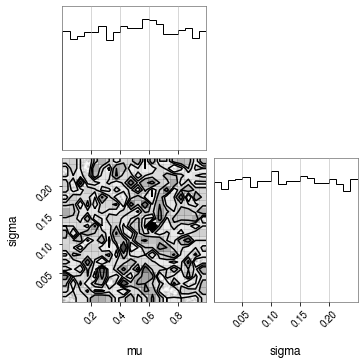

In [13]:
prior_samples = priorsA.sample(10000)
prior_samples_array = np.array([prior_samples['mu_chi_1'], prior_samples['sigma_chi_1']]).T
corner.corner(prior_samples_array, labels=['mu', 'sigma'])
plt.show()

In [14]:
priorsA.evaluate_constraints(prior_samples)

1

In [15]:
priorsA['alpha_chi_1']

Constraint(minimum=1, maximum=2, name=None, latex_label='$\\alpha_{\\chi}_1$', unit=None)

In [16]:
prior_samples

{'amax_1': array([1., 1., 1., ..., 1., 1., 1.]),
 'amax_2': array([1., 1., 1., ..., 1., 1., 1.]),
 'mu_chi_1': array([0.35182948, 0.60324305, 0.24520403, ..., 0.95397099,
        0.22845118, 0.85968327]),
 'mu_chi_2': array([0.34157225, 0.06087052, 0.90319998, ..., 0.03217047,
        0.94248347, 0.53769854]),
 'sigma_chi_1': array([2.14502847e-01, 1.35247477e-01, 9.87769610e-05, ...,
        4.30999871e-02, 2.07583245e-01, 1.88858513e-01]),
 'sigma_chi_2': array([0.1412625 , 0.12100163, 0.20603701, ..., 0.20154739,
        0.01385402, 0.17921267])}

In [9]:
def convert_to_beta_parameters(parameters, remove=False):
    """
    Convert to parameters for standard beta distribution
    """
    added_keys = list()
    converted = parameters.copy()

    def _convert(suffix):
        alpha = f"alpha_chi{suffix}"
        beta = f"beta_chi{suffix}"
        mu = f"mu_chi{suffix}"
        sigma = f"sigma_chi{suffix}"
        amax = f"amax{suffix}"

        if alpha not in parameters.keys() or beta not in parameters.keys():
            needed = True
            print('hi')
        elif converted[alpha] is None or converted[beta] is None:
            needed = True
        else:
            needed = False
            done = True

        if needed:
            if mu in converted.keys() and sigma in converted.keys():
                print('hu')
                done = True
                (
                    converted[alpha],
                    converted[beta],
                    _,
                ) = mu_chi_var_chi_max_to_alpha_beta_max(parameters[mu], parameters[sigma], parameters[amax])
                if remove:
                    added_keys.append(alpha)
                    added_keys.append(beta)
            else:
                done = False
        return done

    done = False

    for suffix in [""]:
        _done = _convert(suffix)
        done = done or _done
    if not done:
        _ = _convert("")

    return converted, added_keys


def alpha_beta_max_to_mu_chi_var_chi_max(alpha, beta, amax):
    """
    Convert between parameters for beta distribution
    """
    mu_chi = alpha / (alpha + beta) * amax
    var_chi = alpha * beta / ((alpha + beta) ** 2 * (alpha + beta + 1)) * amax ** 2
    return mu_chi, var_chi, amax


def mu_chi_var_chi_max_to_alpha_beta_max(mu_chi, var_chi, amax):
    """
    Convert between parameters for beta distribution
    """
    mu_chi /= amax
    var_chi /= amax ** 2
    alpha = (mu_chi ** 2 * (1 - mu_chi) - mu_chi * var_chi) / var_chi
    beta = (mu_chi * (1 - mu_chi) ** 2 - (1 - mu_chi) * var_chi) / var_chi
    return alpha, beta, amax

In [54]:
# def conv(parameters):
#     for suffix in ["_1", "_2"]:
#         parameters["alpha_chi{suffix}""] = parameters['x'] / parameters['y']
#     return parameters

# priorsA = bilby.prior.PriorDict(dict(
    
#     # mass
#     alpha = Uniform(minimum=-4, maximum=12, latex_label='$\\alpha$'), 
#     beta = Uniform(minimum=-4, maximum=12, latex_label='$\\beta$'), 
#     mmin = Uniform(minimum=5, maximum=10, latex_label='$m_{\\min}$'), 
#     mmax = Uniform(minimum=30, maximum=100, latex_label='$m_{\\max}$'), 
#     lam = Uniform(minimum=0, maximum=1, latex_label='$\\lambda_{m}$'), 
#     mpp = Uniform(minimum=20, maximum=50, latex_label='$\\mu_{m}$'), 
#     sigpp = Uniform(minimum=0, maximum=10, latex_label='$\\sigma_{m}$'), 
#     delta_m = Uniform(minimum=0, maximum=10, latex_label='$\\sigma_{m}$'), 

# #     spin magnitude
#     amax_1 = 1, 
#     amax_2 = 1, 
#     mu_chi_1 = Uniform(minimum=0, maximum=1, latex_label = '$\\mu_{\\chi_1}$'), 
#     mu_chi_2 = Uniform(minimum=0, maximum=1, latex_label = '$\\mu_{\\chi_2}$'), 
#     sigma_chi_1 = Uniform(minimum=0, maximum=0.25, latex_label = '$\\sigma_{\\chi_1}$'), 
#     sigma_chi_2 = Uniform(minimum=0, maximum=0.25, latex_label = '$\\sigma_{\\chi_2}$'), 
#     alpha_chi_1 = Constraint(minimum = 1, maximum = 1000, latex_label = '$\\alpha_{\\chi1}$'), 
#     alpha_chi_2 = Constraint(minimum = 1, maximum = 1000, latex_label = '$\\alpha_{\\chi2}$'), 
#     beta_chi_1 = Constraint(minimum = 1, maximum = 1000, latex_label = '$\\beta_{\\chi1}$'), 
#     beta_chi_2 = Constraint(minimum = 1, maximum = 1000, latex_label = '$\\beta_{\\chi2}$'), 

#     # spin orientation
#     xi_spin = Uniform(minimum=0, maximum=1, latex_label='$\\xi$'), 
#     sigma_1 = Uniform(minimum=0, maximum=4, latex_label='$\\sigma{1}$'), 
#     sigma_2 = Uniform(minimum=0, maximum=4, latex_label='$\\sigma{2}$')), 
                               
#                                conversion_function = convert_to_beta_parameters)



# priorsA = PriorDict(dict(), 
#                     conversion_function = convert_to_beta_parameters)

# # rate
# # priorsA['rate'] = LogUniform(minimum=1e-20, maximum=1e20, latex_label='$R$')

# # mass
# priorsA['alpha'] = Uniform(minimum=-4, maximum=12, latex_label='$\\alpha$')
# priorsA['beta'] = Uniform(minimum=-4, maximum=12, latex_label='$\\beta$')
# priorsA['mmin'] = Uniform(minimum=5, maximum=10, latex_label='$m_{\\min}$')
# priorsA['mmax'] = Uniform(minimum=30, maximum=100, latex_label='$m_{\\max}$')
# priorsA['lam'] = Uniform(minimum=0, maximum=1, latex_label='$\\lambda_{m}$')
# priorsA['mpp'] = Uniform(minimum=20, maximum=50, latex_label='$\\mu_{m}$')
# priorsA['sigpp'] = Uniform(minimum=0, maximum=10, latex_label='$\\sigma_{m}$')
# priorsA['delta_m'] = Uniform(minimum=0, maximum=10, latex_label='$\\sigma_{m}$')

# # spin magnitude
# priorsA['amax_1'] = 1
# priorsA['amax_2'] = 1
# priorsA['mu_chi_1'] = Uniform(minimum=0, maximum=1, latex_label = '$\\mu_{\\chi_1}$')
# priorsA['mu_chi_2'] = Uniform(minimum=0, maximum=1, latex_label = '$\\mu_{\\chi_2}$')
# priorsA['sigma_chi_1'] = Uniform(minimum=0, maximum=0.25, latex_label = '$\\sigma_{\\chi_1}$')
# priorsA['sigma_chi_2'] = Uniform(minimum=0, maximum=0.25, latex_label = '$\\sigma_{\\chi_2}$')

# priorsA['alpha_chi_1'], priorsA['beta_chi_1'] = conv(priorsA['mu_chi_1'], priorsA['sigma_chi_1'],
# priorsA['amax_1'])
    
# # priorsA['alpha_chi_1'] = Constraint(minimum = 1, maximum = 1000, latex_label = '$\\alpha_{\\chi1}$')
# # priorsA['alpha_chi_2'] = Constraint(minimum = 1, maximum = 1000, latex_label = '$\\alpha_{\\chi2}$')
# # priorsA['beta_chi_1'] = Constraint(minimum = 1, maximum = 1000, latex_label = '$\\beta_{\\chi1}$')
# # priorsA['beta_chi_2'] = Constraint(minimum = 1, maximum = 1000, latex_label = '$\\beta_{\\chi2}$')

# # spin orientation
# priorsA['xi_spin'] = Uniform(minimum=0, maximum=1, latex_label='$\\xi$')
# priorsA['sigma_1'] = Uniform(minimum=0, maximum=4, latex_label='$\\sigma{1}$')
# priorsA['sigma_2'] = Uniform(minimum=0, maximum=4, latex_label='$\\sigma{2}$')

In [63]:
prior_samples = priorsA.sample(10000)
prior_samples_array = np.array([prior_samples['mu_chi_1'], prior_samples['sigma_chi_1']**2]).T
corner.corner(prior_samples_array, labels = ['$\\mu_{\\chi}$', '$\\sigma_{\\chi}$'])
plt.show()

KeyError: 'mu_chi_1'

In [10]:
priorsA = bilby.prior.PriorDict(dict(
    
    # mass
    alpha = Uniform(minimum=-4, maximum=12, latex_label='$\\alpha$'), 
    beta = Uniform(minimum=-4, maximum=12, latex_label='$\\beta$'), 
    mmin = Uniform(minimum=5, maximum=10, latex_label='$m_{\\min}$'), 
    mmax = Uniform(minimum=30, maximum=100, latex_label='$m_{\\max}$'), 
    lam = Uniform(minimum=0, maximum=1, latex_label='$\\lambda_{m}$'), 
    mpp = Uniform(minimum=20, maximum=50, latex_label='$\\mu_{m}$'), 
    sigpp = Uniform(minimum=0, maximum=10, latex_label='$\\sigma_{m}$'), 
    delta_m = Uniform(minimum=0, maximum=10, latex_label='$\\sigma_{m}$'), 

#     spin magnitude
    amax = 1,  
    mu_chi = Uniform(minimum=0, maximum=1, latex_label = '$\\mu_{\\chi_1}$'), 
#     mu_chi_2 = Uniform(minimum=0, maximum=1, latex_label = '$\\mu_{\\chi_2}$'), 
    sigma_chi = Uniform(minimum=0, maximum=0.25, latex_label = '$\\sigma_{\\chi_1}$'), 
#     sigma_chi_2 = Uniform(minimum=0, maximum=0.25, latex_label = '$\\sigma_{\\chi_2}$'), 
#     alpha_chi = Constraint(minimum = 1, maximum = 1000, latex_label = '$\\alpha_{\\chi1}$'), 
#     alpha_chi_2 = Constraint(minimum = 1, maximum = 1000, latex_label = '$\\alpha_{\\chi2}$'), 
#     beta_chi = Constraint(minimum = 1, maximum = 1000, latex_label = '$\\beta_{\\chi1}$'), 
#     beta_chi_2 = Constraint(minimum = 1, maximum = 1000, latex_label = '$\\beta_{\\chi2}$'), 

    # spin orientation
    xi_spin = Uniform(minimum=0, maximum=1, latex_label='$\\xi$'), 
    sigma_1 = Uniform(minimum=0, maximum=4, latex_label='$\\sigma{1}$'), 
    sigma_2 = Uniform(minimum=0, maximum=4, latex_label='$\\sigma{2}$')), 
                               
                               conversion_function = convert_to_beta_parameters)


hi
hu


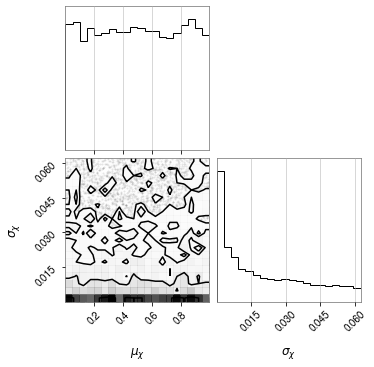

In [11]:
prior_samples = priorsA.sample(10000)
prior_samples_array = np.array([prior_samples['mu_chi'], prior_samples['sigma_chi']**2]).T
corner.corner(prior_samples_array, labels = ['$\\mu_{\\chi}$', '$\\sigma_{\\chi}$'])
plt.show()

In [49]:
# def conv(mu_chi, var_chi, amax):
#     mu_chi /= amax
#     var_chi /= amax ** 2
#     alpha = (mu_chi ** 2 * (1 - mu_chi) - mu_chi * var_chi) / var_chi
#     beta = (mu_chi * (1 - mu_chi) ** 2 - (1 - mu_chi) * var_chi) / var_chi
#     return alpha, beta

In [47]:
# prior_samples = priorsA.sample(10000)
# prior_samples
# # prior_samples_array = np.array([prior_samples['alpha_chi_1'], prior_samples['alpha_chi_2']]).T
# # corner.corner(prior_samples_array, labels=['mu', 'sigma'])
# # plt.show()

{'alpha': array([-3.55085504,  3.40800609, -0.72341774, ...,  5.11984224,
         7.85958875,  0.94987944]),
 'beta': array([ 6.41948246,  3.56233538, -3.8645112 , ..., 10.21729049,
         8.37493   ,  0.09222859]),
 'mmin': array([7.10951833, 5.7521077 , 9.47404911, ..., 8.17737996,
        6.7367078 , 9.98794494]),
 'mmax': array([59.75589998, 77.9770466 , 38.76445791, ..., 31.51835834,
        97.90981044, 93.52590847]),
 'lam': array([0.74422799, 0.3602063 , 0.46022576, ..., 0.05637886,
        0.851417  , 0.83606191]),
 'mpp': array([26.50981156, 38.186211  , 44.6852682 , ..., 49.57252453,
        42.58001828, 40.34890913]),
 'sigpp': array([5.33933619, 2.82258367, 4.86992904, ..., 9.71659314,
        5.19377797, 0.6349404 ]),
 'delta_m': array([9.62598941, 4.80479433, 6.75038623, ..., 6.20298927,
        3.15003746, 9.03937535]),
 'amax_1': array([1., 1., 1., ..., 1., 1., 1.]),
 'amax_2': array([1., 1., 1., ..., 1., 1., 1.]),
 'mu_chi_1': array([0.5438232 , 0.001375  , 0.39060

In [81]:
likelihoodA = gwpop.hyperpe.HyperparameterLikelihood(posteriors=posteriors, 
                                                     hyper_prior=modelA, 
                                                     conversion_function = convert_to_beta_parameters)

15:50 bilby WARNING : Cannot import cupy, falling back to numpy.
15:50 bilby INFO    : No prior values provided, defaulting to 1.


In [82]:
likelihoodA.parameters.update(priorsA.sample())
likelihoodA.log_likelihood_ratio()

hi
hu


/home/deepnika/anaconda3/envs/bilbyenv/lib/python3.7/site-packages/gwpopulation-0.5.0-py3.7.egg/gwpopulation/models/mass.py:434: RuntimeWarning: overflow encountered in exp
  window[smoothing_region] = 1 / (xp.exp(exponent) + 1)


-110.94861601505495

In [83]:
likelihoodA.parameters

{'alpha': 5.34151251969673,
 'beta': 8.881536686442852,
 'mmin': 6.124592505619419,
 'mmax': 90.66029761378196,
 'lam': 0.35460129534356355,
 'mpp': 46.05257189452252,
 'sigpp': 0.44462768318188406,
 'delta_m': 5.546649647924989,
 'amax_1': 1.0,
 'amax_2': 1.0,
 'mu_chi_1': 0.31552178748239124,
 'mu_chi_2': 0.9382195439424111,
 'sigma_chi_1': 0.14971300781643337,
 'sigma_chi_2': 0.04434578209600415,
 'xi_spin': 0.7363273031949286,
 'sigma_1': 3.0659464696688077,
 'sigma_2': 3.120052165735451,
 'alpha_chi_1': 0.06148470960785457,
 'beta_chi_1': 0.09942648845575826,
 'alpha_chi_2': 0.005597712252721128,
 'beta_chi_2': 0.006913998489175552,
 'amax': 1.0,
 'mu_chi': 0.30989383324708797,
 'sigma_chi': 0.2407176807067459,
 'alpha_chi': 2.065697729019037,
 'beta_chi': 6.8134867626849935}

In [30]:
resultA = bilby.run_sampler(likelihood = likelihoodA, priors = priorsA, sampler='emcee', nlive=5, 
                            label='Default', outdir = 'Default', clean = True, 
                           conversion_function=bilby.gw.conversion.generate_all_bbh_parameters)

NameError: name 'likelihoodA' is not defined

# Part 2

In [12]:
import bilby
import gwpopulation as gwpop
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import corner

from astropy import cosmology, units
from scipy.interpolate import interp1d
from scipy.special import erf

from bilby.core.prior import Uniform, LogUniform, PriorDict, Constraint
from gwpopulation.models import mass, spin

# Model B - Gaussian

This paper uses `Overall_posterior`.

In [5]:
parameter_translator = dict(
    mass_1_det = 'm1_detector_frame_Msun',
    mass_2_det = 'm2_detector_frame_Msun',
    luminosity_distance = 'luminosity_distance_Mpc',
    a_1 = 'spin1',
    a_2 = 'spin2',
    cos_tilt_1 = 'costilt1',
    cos_tilt_2 = 'costilt2')

In [6]:
file = 'GWTC-1_sample_release/GW{}_GWTC-1.hdf5'

events = ['150914', '151012', '151226', '170104', '170608', '170729', '170809', '170814', 
          '170818', '170823']

posteriorsB = list()

for event in events:
    _posterior = pd.DataFrame()
    _prior = pd.DataFrame()
    with h5py.File(file.format(event), 'r') as ff:
        for my_key, gwtc_key in parameter_translator.items():
            _posterior[my_key] = ff['Overall_posterior'][gwtc_key]
    posteriorsB.append(_posterior)

In [7]:
luminosity_distances = np.linspace(1, 10000, 1000)
redshifts = np.array([cosmology.z_at_value(cosmology.Planck15.luminosity_distance, 
                                                   dl * units.Mpc) for dl in luminosity_distances])
dl_to_z = interp1d(luminosity_distances, redshifts)

In [8]:
def chi_eff(a1, a2, q, cost1, cost2):
    chieff = (a1*cost1 + a2*q*cost2)/(1+q)
    return chieff

In [9]:
for posterior in posteriorsB:
    posterior['redshift'] = dl_to_z(posterior['luminosity_distance'])
    posterior['mass_1'] = posterior['mass_1_det'] / (1 + posterior['redshift'])
    posterior['mass_2'] = posterior['mass_2_det'] / (1 + posterior['redshift'])
    posterior['mass_ratio'] = posterior['mass_2'] / posterior['mass_1']
    posterior['chi_eff'] = chi_eff(posterior['a_1'], posterior['a_2'], posterior['mass_ratio'], 
                                   posterior['cos_tilt_1'], posterior['cos_tilt_2'])

In [10]:
posteriorsB[0]

,mass_1_det,mass_2_det,luminosity_distance,a_1,a_2,cos_tilt_1,cos_tilt_2,redshift,mass_1,mass_2,mass_ratio,chi_eff
0,40.823686,26.440697,429.439630,0.720602,0.536915,-0.591917,0.188768,0.090895,37.422188,24.237614,0.647680,-0.219031
1,34.626875,34.212308,337.154490,0.238156,0.410068,-0.076179,-0.517005,0.072273,32.292953,31.906329,0.988028,-0.114491
2,36.142271,33.174642,487.316326,0.297883,0.187064,-0.335351,-0.821574,0.102359,32.786286,30.094216,0.917890,-0.125640
3,41.569619,31.876132,488.540224,0.347413,0.059700,0.109706,-0.500742,0.102600,37.701443,28.909964,0.766813,0.008597
4,37.869125,33.759950,463.788715,0.147665,0.086681,-0.761297,0.988754,0.097718,34.498038,30.754659,0.891490,-0.019038
...,...,...,...,...,...,...,...,...,...,...,...,...
8345,40.383795,31.959753,460.559361,0.088515,0.577331,0.870492,-0.264759,0.097079,36.810276,29.131669,0.791400,-0.024515
8346,38.164225,35.639218,449.985818,0.122339,0.190940,0.783595,0.267030,0.094983,34.853703,32.547725,0.933838,0.074193
8347,37.670359,34.004716,513.756334,0.439794,0.470269,-0.208949,0.113237,0.107545,34.012487,30.702786,0.902692,-0.023033
8348,36.746741,35.672009,399.113830,0.163340,0.423884,0.160240,0.171165,0.084824,33.873472,32.882775,0.970753,0.049020


### Sampling effective spins ($\chi_{eff}$) from a truncated Gaussian

Effective spins are drawn from a simple truncated Gaussian.

<img src="chieff.png">


In [29]:
def truncated_gaussian(dataset, mu, var):
    norm = (2/(np.pi*var))**0.5 * (erf((1-mu)/(2*var)**0.5) + erf((1+mu)/(2*var)**0.5))**(-1)
    prob = np.exp(-(dataset['chi_eff'] - mu)**2 / (2 * var))
    return norm*prob

In [30]:
chieff_prior = PriorDict(dict(mu = Uniform(minimum = -1, maximum = 1, latex_label = "$\\mu$"),
                              var = Uniform(minimum = 0, maximum = 1, latex_label = "$\\sigma^2$")))

In [31]:
likelihoodB = gwpop.hyperpe.HyperparameterLikelihood(posteriors = posteriorsB,
                                                     hyper_prior = truncated_gaussian)

05:26 bilby WARNING : Cannot import cupy, falling back to numpy.
05:26 bilby INFO    : No prior values provided, defaulting to 1.


In [32]:
likelihoodB.parameters.update(chieff_prior.sample())

In [38]:
resultA = bilby.run_sampler(likelihood = likelihoodB, priors = chieff_prior, sampler='dynesty', nlive=150, 
                            label='Default', outdir = 'Default', clean = True)

05:36 bilby INFO    : Running for label 'Default', output will be saved to 'Default'
05:36 bilby INFO    : Search parameters:
05:36 bilby INFO    :   mu = Uniform(minimum=-1, maximum=1, name=None, latex_label='$\\mu$', unit=None, boundary=None)
05:36 bilby INFO    :   var = Uniform(minimum=0, maximum=1, name=None, latex_label='$\\sigma^2$', unit=None, boundary=None)
05:36 bilby INFO    : Single likelihood evaluation took 1.462e-03 s


0it [00:00, ?it/s]

05:36 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 150, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 90, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f8573b6b590>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
05:36 bilby INFO    : Checkpoint every check_point_delta_t = 600s
05:36 bilby INFO    : Using dynesty version 1.0.1
05:36 bilby INFO    : Generating initial points from the prio

537it [00:15,  2.36it/s, bound:18 nc:321 ncall:1.1e+04 eff:4.7% logz-ratio=-3.98+/-0.17 dlogz:7.778>0.1] 

/home/deepnika/anaconda3/envs/bilbyenv/lib/python3.7/site-packages/gwpopulation-0.5.0-py3.7.egg/gwpopulation/hyperpe.py:138: RuntimeWarning: divide by zero encountered in log
  xp.sum(self.hyper_prior.prob(self.data) / self.sampling_prior, axis=-1)


1551it [02:38,  7.15it/s, bound:1032 nc:101 ncall:1.2e+05 eff:1.3% logz-ratio=1.04+/-0.27 dlogz:0.101>0.1]

05:38 bilby INFO    : Written checkpoint file Default/Default_resume.pickle
05:38 bilby INFO    : Writing 562 current samples to Default/Default_samples.dat


1551it [02:45,  9.36it/s, bound:1032 nc:  1 ncall:1.2e+05 eff:1.4% logz-ratio=1.11+/-0.28 dlogz:0.001>0.1]

05:38 bilby INFO    : Sampling time: 0:02:38.147837
05:38 bilby INFO    : Summary of results:
nsamples: 1701
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.284
ln_bayes_factor:  1.107 +/-  0.284



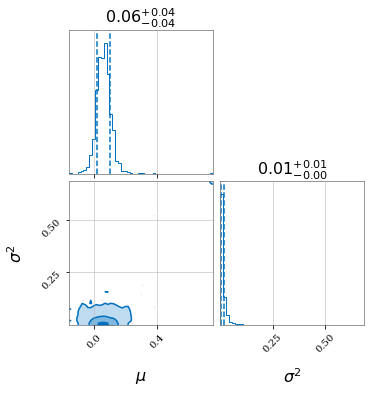

In [43]:
resultA.plot_corner(plot_density = True)

In [49]:
resultA.plot_marginals([''])

09:16 bilby INFO    : Plotting mu marginal distribution
09:16 bilby INFO    : Plotting mu marginal distribution


In [ ]:
priorsB = bilby.prior.PriorDict(dict(
    
    # mass
    alpha = Uniform(minimum=-4, maximum=12, latex_label='$\\alpha$'), 
    beta = Uniform(minimum=-4, maximum=12, latex_label='$\\beta$'), 
    mmin = Uniform(minimum=5, maximum=10, latex_label='$m_{\\min}$'), 
    mmax = Uniform(minimum=30, maximum=100, latex_label='$m_{\\max}$'), 
    lam = Uniform(minimum=0, maximum=1, latex_label='$\\lambda_{m}$'), 
    mpp = Uniform(minimum=20, maximum=50, latex_label='$\\mu_{m}$'), 
    sigpp = Uniform(minimum=0, maximum=10, latex_label='$\\sigma_{m}$'), 
    delta_m = Uniform(minimum=0, maximum=10, latex_label='$\\sigma_{m}$'), 

    # spin magnitude
    amax = 1,  
    mu_chi = Uniform(minimum=0, maximum=1, latex_label = '$\\mu_{\\chi_1}$'), 
#     mu_chi_2 = Uniform(minimum=0, maximum=1, latex_label = '$\\mu_{\\chi_2}$'), 
    sigma_chi = Uniform(minimum=0, maximum=0.25, latex_label = '$\\sigma_{\\chi_1}$'), 
#     sigma_chi_2 = Uniform(minimum=0, maximum=0.25, latex_label = '$\\sigma_{\\chi_2}$'), 
#     alpha_chi = Constraint(minimum = 1, maximum = 1000, latex_label = '$\\alpha_{\\chi1}$'), 
#     alpha_chi_2 = Constraint(minimum = 1, maximum = 1000, latex_label = '$\\alpha_{\\chi2}$'), 
#     beta_chi = Constraint(minimum = 1, maximum = 1000, latex_label = '$\\beta_{\\chi1}$'), 
#     beta_chi_2 = Constraint(minimum = 1, maximum = 1000, latex_label = '$\\beta_{\\chi2}$'), 

    # spin orientation
    xi_spin = Uniform(minimum=0, maximum=1, latex_label='$\\xi$'), 
    sigma_1 = Uniform(minimum=0, maximum=4, latex_label='$\\sigma{1}$'), 
    sigma_2 = Uniform(minimum=0, maximum=4, latex_label='$\\sigma{2}$')), 
                               
                               conversion_function = convert_to_beta_parameters)

In [17]:
modelB = bilby.hyper.model.Model([mass.])

In [67]:
priorsB = PriorDict()

priorsB['mu'] = Uniform(minimum = -1, maximum = 1, latex_label='$\\mu$')
priorsB['var'] = Uniform(minimum = 0, maximum = 1, latex_label='$\\sigma^2$')

# rate
# priorsB['rate'] = LogUniform()

# mass
priorsB['mass_1'] = LogUniform(minimum = , maximum = , latex_label = "$mass_1$")
priorsB['mass_ratio'] = Uniform(minimum = , maximum = , latex_label = "$q$")
priorsB['lam'] = 2.7
priorsB['mmin'] = 5


In [69]:
# likelihoodB.parameters.update(priorsB.sample())
# # likelihoodB.log_likelihood_ratio()

# resultB = bilby.run_sampler(likelihood = likelihoodB, priors = priorsB, sampler='dynesty', nlive=100)

The posterior distribution for mean and variance is:

<img src="posterior_mu_var.png">

# Rough Work

A coalescing compact binary in a quasicircular orbit can be completely characterized by its intrinsic parameters, namely its individual masses mi and spins Si, and its seven extrinsic parameters: right ascension, declination, luminosity distance, coalescence time, and three Euler angles characterizing its orientation (e.g., inclination,
orbital phase, and polarization). In this work, we will also use the total mass M = m1 + m2 and mass ratio q
defined in the following way:

q = m2/m1, where m1 ≥ m2. (1)

We will also refer to two other commonly used mass parametrizations: 
the chirp mass Mc = (m1m2)
3/5/(m1 + m2)
1/5 and the symmetric mass ratio
η = m1m2/(m1 + m2)
2
With regard to spin, we define an effective spin [46–48], which is a combination of the spin components along the orbital angular momentum direction Lˆ, in the following way:

χeff = (S1/m1 + S2/m2) · Lˆ/M (2)

where S1 and S2 are the spins on the individual BH. We will also characterize BH spins using the dimensionless
spin variables

χi = Si/m2i. (3)

We will express these dimensionless spins in terms of Cartesian components χi,x, χi,y, χi,z, expressed relative
to a frame with ˆz = Lˆ and (for simplicity) at the orbital frequency corresponding to the earliest time of astrophysical interest (e.g., an orbital frequency of ' 10 Hz).

170817 not inculded in this analysis

In [11]:
# Since this file has different headers

f = h5py.File('GWTC-1_sample_release/GW170817_GWTC-1.hdf5', 'r')
f.keys()

<KeysViewHDF5 ['IMRPhenomPv2NRT_highSpin_posterior', 'IMRPhenomPv2NRT_highSpin_prior', 'IMRPhenomPv2NRT_lowSpin_posterior', 'IMRPhenomPv2NRT_lowSpin_prior']>

In [27]:
luminosity_prior = luminosity_distances ** 2

dz_ddl = np.gradient(redshifts, luminosity_distances)
plt.plot(dz_ddl)
plt.show()

redshift_prior = scipy.interpolate.interp1d(redshifts, luminosity_prior/(dz_ddl*(1 + redshifts)))